# PINN for burgers equation

我们希望使用PINN求解如下的方程。

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

步骤基本上可以分成：

1. 生成数据
2. 构建神经网络作为解的逼近
3. 构建损失函数
4. 训练网络
5. 可视化结果

我们下面首先导入必备的python库

In [1]:
import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt
device='cuda' if torch.cuda.is_available() else 'cpu'

## 生成数据

下面我们首先生成数据。

使用PINN求解正问题的数据主要就是初值和边值。还要生成内部采样点的坐标。这些数据既可以在边训练边生成，也可以提前生成好，我们这里选取提前生成好的形式。

对于初值，我们要生成若干$(x,t,u)$的数据对，满足 $u(0,x) = - \sin(\pi \, x), \quad x \in [-1,1]$.
这里我们选择了在边界等距采样，实际上也可以换成随机均匀采样。

In [2]:
xmin=-1
xmax=1
nx=100
tmin=0
tmax=1
nt=100
n_samples=10000
nu=0.01/math.pi

IV_x=torch.linspace(xmin,xmax,nx).to(device=device)
IV_t=torch.zeros_like(IV_x).to(device=device)
IV_u=-torch.sin(math.pi*IV_x).to(device=device)

对于边界条件，我们依据
$  u(t,-1) = u(t,1) = 0,\quad  t \in (0,1] $
分别生成若干左边界和右边界的数据点。

In [3]:
BV_xL=-torch.ones(nt)
BV_tL=torch.linspace(tmin,tmax,nt)
BV_uL=torch.zeros_like(BV_xL)
BV_xR=torch.ones(nt)
BV_tR=torch.linspace(tmin,tmax,nt)
BV_uR=torch.zeros_like(BV_xR)

BV_x=torch.cat([BV_xL,BV_xR]).to(device=device)
BV_t=torch.cat([BV_tL,BV_tR]).to(device=device)
BV_u=torch.cat([BV_uL,BV_uR]).to(device=device)

然后我们再生成区域内部的采样点坐标，这些点只有$(x,t)$，没有$u$。

In [4]:
IN_x=torch.rand((n_samples,))*2-1
IN_t=torch.rand((n_samples,))
IN_x=IN_x.requires_grad_().to(device=device)
IN_t=IN_t.requires_grad_().to(device=device)

我们可视化一下生成的数据点分布。

Text(0, 0.5, 't')

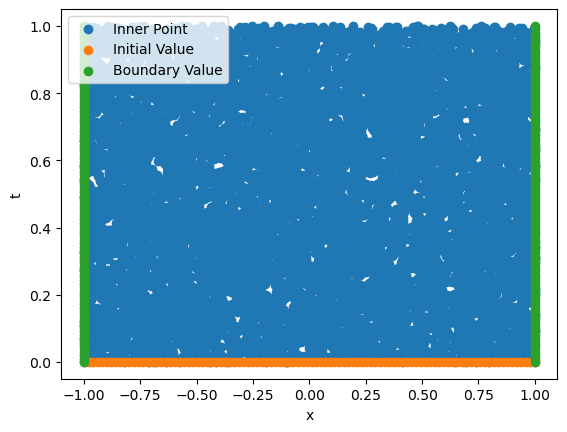

In [5]:
plt.scatter(IN_x.cpu().detach().numpy(),IN_t.cpu().detach().numpy(),label="Inner Point")
plt.scatter(IV_x.cpu().detach().numpy(),IV_t.cpu().detach().numpy(),label="Initial Value")
plt.scatter(BV_x.cpu().detach().numpy(),BV_t.cpu().detach().numpy(),label="Boundary Value")
plt.legend()
plt.xlabel("x")
plt.ylabel("t")

## 构建网络

我们构建一个全连接网络用来作为方程解的拟设（Ansatz）。

In [6]:
class FCN(nn.Module):
    def __init__(self,neurons,activation):
        super().__init__()
        self.act=activation
        self.linears = nn.ModuleList([nn.Linear(neurons[i], neurons[i+1]) for i in range(len(neurons)-1)])
    def forward(self,x):
        for layer in self.linears[:-1]:
            x=layer(x)
            x=self.act(x)
        x=self.linears[-1](x)
        return x
    
class Ansatz(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=FCN([2,20,20,20,20,20,20,1],torch.sin)
    def forward(self,x,t):
        xt=torch.stack([x,t],dim=-1)
        y=self.net(xt)
        return y

## 构建损失函数

损失函数分为3部分，分别是初值的损失函数、边值的损失函数，以及内点的残差损失函数。

我们先定义内点的损失函数，下面是比较传统的使用pytorch计算导数的方法，并基于此构建损失函数。

In [7]:
def pinn_loss(x,t,net,nu):
    u=net(x,t)[...,0]
    du_dt=torch.autograd.grad(u.sum(),t,create_graph=True)[0]
    du_dx=torch.autograd.grad(u.sum(),x,create_graph=True)[0]
    ddu_dxx=torch.autograd.grad(du_dx.sum(),x,create_graph=True)[0]
    loss=du_dt+u*du_dx-nu*ddu_dxx
    return loss.square().mean()

PyTorch最新的版本推出了函数变换功能，可以更方便的获取导数。我推荐使用torch.func相关的API进行符号求导，更加自由。

In [8]:
def pinn_loss(x,t,net,nu):
    u=net(x,t)[...,0]
    du=torch.func.jacrev(net,argnums=(0,1))
    du_dx,du_dt=torch.vmap(du)(x,t)

    ddu=torch.func.jacrev(lambda x,t:du(x,t)[0],argnums=(0,))
    ddu_dxx,=torch.vmap(ddu)(x,t)
    
    du_dx=du_dx.reshape(u.shape)
    du_dt=du_dt.reshape(u.shape)
    ddu_dxx=ddu_dxx.reshape(u.shape)
    loss=du_dt+u*du_dx-nu*ddu_dxx
    return loss.square().mean()

下面则是定义关于初值和边值的误差

In [9]:
def mse_loss(x,y):
    return (x.flatten()-y.flatten()).square().mean()

def initial_loss(x,t,net,u):
    u_pred=net(x,t)
    loss=mse_loss(u_pred,u)
    return loss
    
def boundary_loss(x,t,net,u):
    u_pred=net(x,t)
    loss=mse_loss(u_pred,u)
    return loss

## 训练网络

在训练网络的过程中，我们使用Adam优化器和CosineAnnealingWarmRestarts学习率调整器，并且记录每一步的总损失函数。

In [ ]:
model=Ansatz().to(device=device)

optimizer=torch.optim.Adam( model.parameters(), lr=1e-3)
scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,5000,2)
epochs=5000
loss_hist=[]

for i in range(1,1+epochs):
    optimizer.zero_grad()

    loss_IV=initial_loss(IV_x,IV_t,model,IV_u)
    loss_BV=boundary_loss(BV_x,BV_t,model,BV_u)
    loss_pinn=pinn_loss(IN_x,IN_t,model,nu)
    loss_sum=loss_IV+loss_BV+loss_pinn
    
    loss_hist.append(loss_sum.item())
    loss_sum.backward()
    optimizer.step()
    scheduler.step()
    if i%1000==0:
        print(f"{i}:{loss_IV:.2e},{loss_BV:.2e},{loss_pinn:.2e}")

1000:2.62e-02,1.16e-04,2.11e-02
2000:3.18e-03,2.18e-05,3.25e-03


## 可视化训练结果

下面画出了t=0时的初值和网络预测值，以及t=1时的网络预测值。

In [ ]:
IV_x=torch.linspace(xmin,xmax,nx).to(device=device)
IV_t=0.0*torch.ones_like(IV_x).to(device=device)

VA_x=torch.linspace(xmin,xmax,nx).to(device=device)
VA_t=1.0*torch.ones_like(IV_x).to(device=device)

with torch.no_grad():
    VA_pred=model(VA_x,VA_t)
    IV_pred=model(IV_x,IV_t)

plt.plot(IV_u.detach().cpu().numpy(),label='ref t=0')
plt.plot(IV_pred.detach().cpu().numpy()[...,0],label='pred t=0')
plt.plot(VA_pred.detach().cpu().numpy()[...,0],label='pred t=1')
plt.legend()

下面则是训练过程中误差的下降曲线

In [ ]:
plt.plot(loss_hist)
plt.yscale('log')